<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [Basic Transit Models](01.06-Basic-Transit-Model.ipynb) | [Contents](index.ipynb) | [Which Flux to Use](02.03-Contaminants-And-Apertures.ipynb) >

# Fitting Transit Models with Scipy Minimize

Now that we understand how to initialize the model we can use scipy minimize to find the best fitting parameters. This will allow us to find the best fitting transit model based on our data. 

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.constants import G
from math import pi
from pyke import lightcurve as lcf
%matplotlib inline

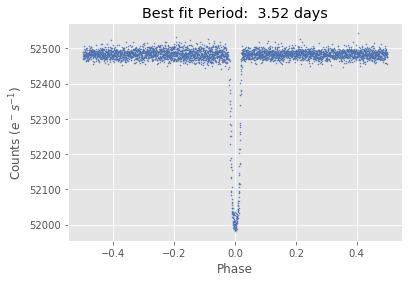

In [31]:
lc = lcf.KeplerLightCurveFile('data/kplr006922244-2010078095331_llc.fits',quality_mask='hard')
lc.fold('PDCSAP_FLUX',minper=1,maxper=20,double=True,plot=True)

In [62]:
phase,time,flux,err = lc.folded_time,lc.time,lc.PDCSAP_FLUX.flux,lc.PDCSAP_FLUX.flux_err
ok = np.isfinite(flux)
phase,time,flux,err = phase[ok], time[ok], flux[ok], err[ok]

In [63]:
teff = lc.header()['TEFF']
logg = lc.header()['LOGG']
feh = lc.header()['FEH']
r= lc.header()['RADIUS']*u.solRad

g = 10.**(logg)*(u.cm/u.second**2)
m = ((g*r**2)/G).to(u.solMass)

In [89]:
rp_init=((np.median(flux)-np.min(flux))/np.median(flux))**0.5
i_init=90
per = lc.period
t0_init=0
d=(((per*u.day).to(u.second))**2*G*m/(4*pi**2))**(1./3.)
a_init=(d.to(u.solRad)/r).value

In [104]:
import batman
params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients
params.per = per                      #orbital period



def func(guess,return_model=False):
    params.rp=guess[0]
    params.a=guess[1]
    params.inc=guess[2]
    params.t0=guess[3]
    
    m = batman.TransitModel(params, phase*per)
    model=m.light_curve(params)*np.nanmedian(flux)
    
    if return_model:
        return(model)
    else:
        return((np.nansum((flux-model)**2/flux)))

In [111]:
from scipy.optimize import minimize
res=minimize(func,[rp_init,a_init,i_init,t0_init],method='Powell')

In [112]:
lcm = func([rp_init,a_init,i_init,t0_init,0.5230,0.1218],return_model=True)
lcm_fit = func(res.x,return_model=True)

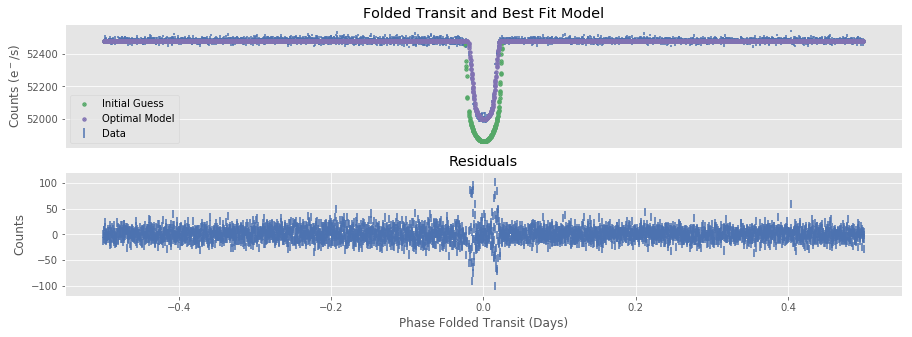

In [113]:
fig,ax=plt.subplots(2,figsize=(15,5))
ax[0].errorbar(phase,flux,err,ls='',label='Data')
ax[0].set_ylabel('Counts (e$^-$/s)')
ax[0].scatter(phase,lcm,c='C1',label='Initial Guess',lw=3,s=2,zorder=1)
ax[0].scatter(phase,lcm_fit,c='C3',label='Optimal Model',lw=3,s=2,zorder=2)
ax[0].legend()
ax[0].set_xticks([])
ax[0].set_title('Folded Transit and Best Fit Model')

ax[1].errorbar(phase,flux-lcm_fit,err,ls='',label='Data')
ax[1].set_xlabel('Phase Folded Transit (Days)')
ax[1].set_ylabel('Counts')
ax[1].set_title('Residuals')

<!--NAVIGATION-->
< [Basic Transit Models](01.06-Basic-Transit-Model.ipynb) | [Contents](index.ipynb) | [Which Flux to Use](02.03-Contaminants-And-Apertures.ipynb) >